# Upload dataset

In [1]:
! pip install -q kaggle



In [1]:
""" from google.colab import files
 files.upload()"""

' from google.colab import files\n files.upload()'

In [3]:
! mkdir ~/.kaggle

In [4]:
! cp kaggle.json ~/.kaggle/



In [5]:
! chmod 600 ~/.kaggle/kaggle.json



In [6]:
!kaggle datasets download -d masoudnickparvar/brain-tumor-mri-dataset


100% 148M/149M [00:00<00:00, 201MB/s]
100% 149M/149M [00:00<00:00, 176MB/s]


In [7]:
!unzip -qq brain-tumor-mri-dataset.zip


# Libraries

In [9]:
import cv2
import os
import matplotlib.pyplot as plt

from tqdm import tqdm #progress barr

import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
from torchvision.datasets import ImageFolder
import torch.nn as nn
import torch.optim as optim
import torchvision


# Files

In [10]:
glioma_path = "/content/Training/glioma"
meningioma_path = "/content/Training/meningioma"
notumor_path = "/content/Training/notumor"
pituitary_path = "/content/Training/pituitary"

glioma_list = os.listdir(glioma_path)
meningioma_list = os.listdir(meningioma_path)
notumor_list = os.listdir(notumor_path)
pituitary_list = os.listdir(pituitary_path)



# Plotting


In [16]:
def plot_images_in_folder(folder_path, num_images, figsize=(20, 12)):

    file_list = os.listdir(folder_path)
    fig, axs = plt.subplots(1, num_images, figsize=figsize)
    for i, file_name in enumerate(file_list[:num_images]):
        img = cv2.imread(os.path.join(folder_path, file_name))
        img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        axs[i].imshow(img_rgb)
        axs[i].set_title(file_name)
        axs[i].axis('off')

    plt.show()

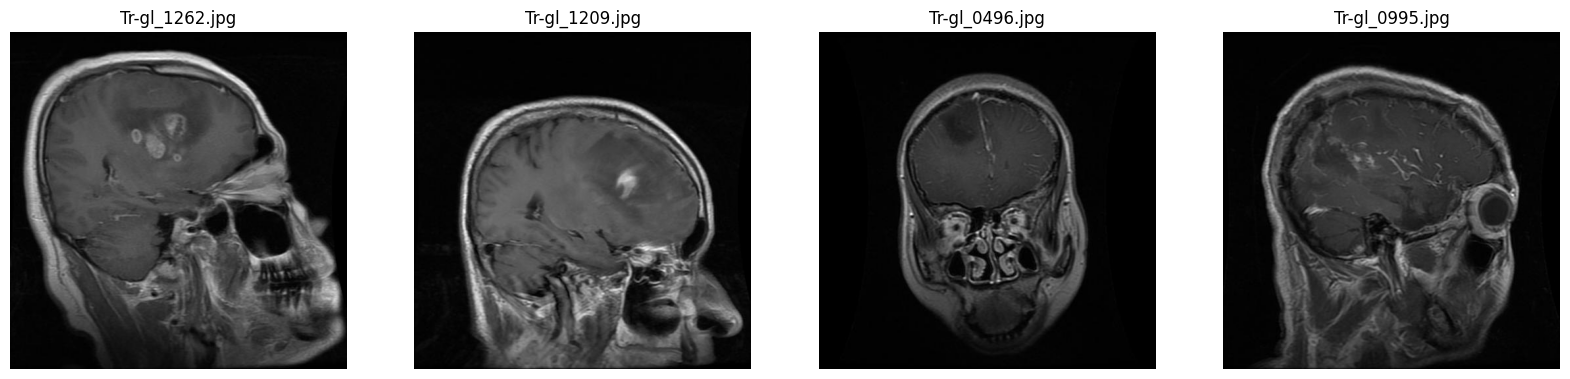

In [18]:
plot_images_in_folder(glioma_path,num_images=4)

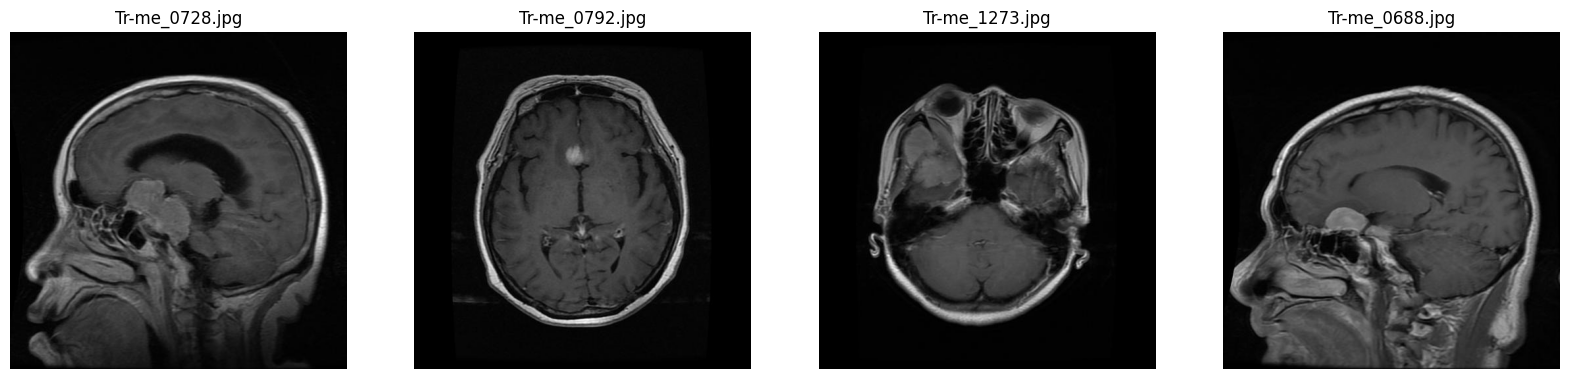

In [19]:
plot_images_in_folder(meningioma_path,num_images=4)

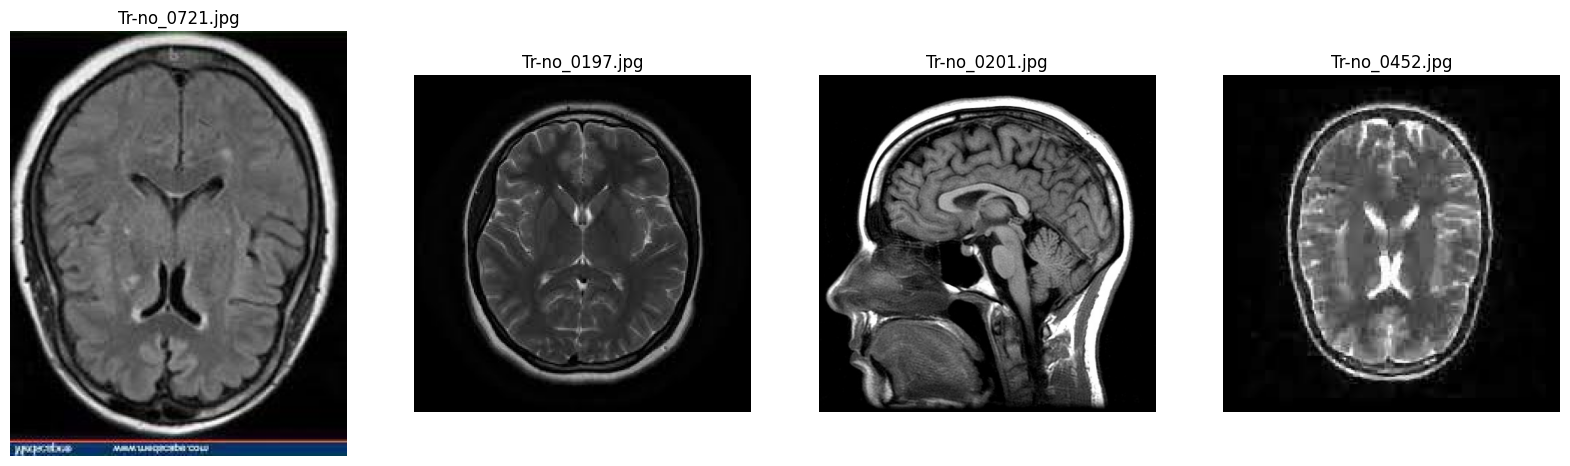

In [20]:
plot_images_in_folder(notumor_path,num_images=4)

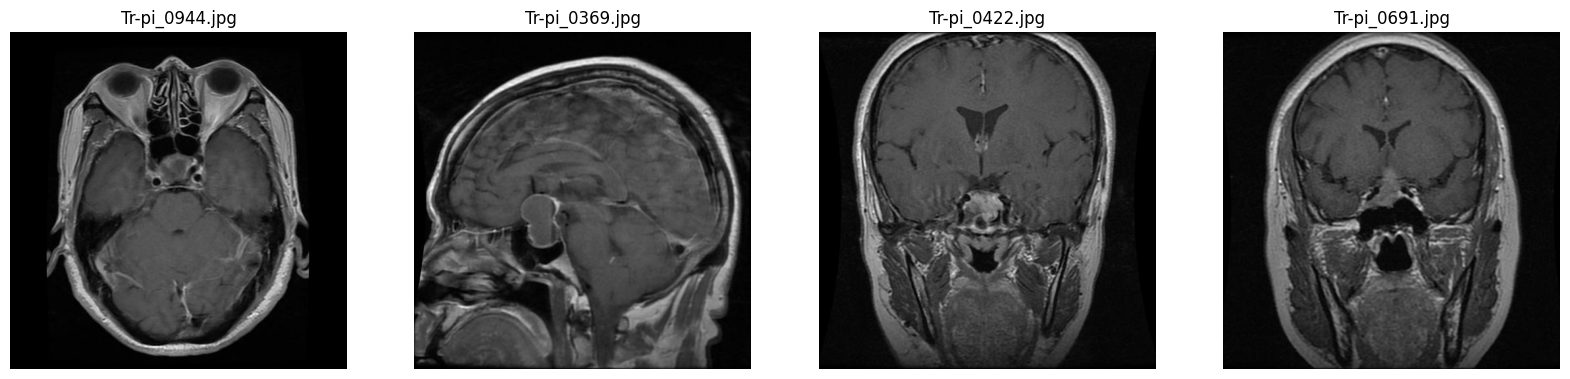

In [21]:
plot_images_in_folder(pituitary_path,num_images=4)

# Preparing dataset

In [22]:
IMAGE_SIZE = 224
mean, std = [0.4914, 0.4822, 0.4465], [0.247, 0.243, 0.261]
batch_size = 32

composed_train = transforms.Compose([transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)), # Resize the image in a 224X224 shape
                                     transforms.RandomRotation(20), # Randomly rotate some images by 20 degrees
                                     transforms.RandomHorizontalFlip(0.1), # Randomly horizontal flip the images
                                     transforms.ToTensor(), # Converting image to tensor
                                     transforms.Normalize(mean, std),]) # Normalizing with standard mean and standard deviation


composed_test = transforms.Compose([transforms.Resize((IMAGE_SIZE,IMAGE_SIZE)),
                                    transforms.ToTensor(),
                                    transforms.Normalize(mean, std)])

#Image folder to dataset
train_dataset = ImageFolder(root="/content/Training", transform=composed_train)
test_dataset = ImageFolder(root="/content/Testing", transform=composed_test)

# Dataset to DataLoader
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [23]:
# choosing device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [24]:
# using resnet as a model
model = torchvision.models.resnet50(pretrained=True)
model.fc = nn.Sequential(
    nn.Linear(2048, 512),
    nn.ReLU(),
    nn.Dropout(0.2),
    nn.Linear(512, 4),
    nn.Softmax(dim=1)
)
lr = 0.001
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=lr)

model.to(device)


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 161MB/s]


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [25]:
num_epochs = 20
train_losses = []  # Store training losses for plotting
val_losses = [] #Store val_losses for plotting
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    train_loader_iter = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}", leave=False)
    for images, labels in train_loader_iter:
        # Move images and labels to GPU
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        train_loader_iter.set_postfix(train_loss=loss.item())

    # Store training loss for this epoch
    train_losses.append(running_loss / len(train_loader))

    # Validation loop
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0
    val_loader_iter = tqdm(test_loader, desc="Validation", leave=False)
    with torch.no_grad():
        for images, labels in val_loader_iter:
            # Move images and labels to GPU
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            val_loader_iter.set_postfix(val_loss=loss.item())

    # Store validation loss for this epoch
    val_losses.append(val_loss / len(test_loader))

    print(f'Epoch [{epoch+1}/{num_epochs}], '
          f'Training Loss: {train_losses[-1]:.4f}, '
          f'Validation Loss: {val_losses[-1]:.4f}, '
          f'Validation Accuracy: {(100 * correct / total):.2f}%')



Epoch [1/20], Training Loss: 1.0788, Validation Loss: 1.2899, Validation Accuracy: 45.16%


Epoch [2/20], Training Loss: 1.0605, Validation Loss: 1.1768, Validation Accuracy: 56.67%


Epoch [3/20], Training Loss: 1.0779, Validation Loss: 1.2147, Validation Accuracy: 52.17%


Epoch [4/20], Training Loss: 1.0469, Validation Loss: 1.0472, Validation Accuracy: 69.41%


Epoch [5/20], Training Loss: 1.0521, Validation Loss: 1.1382, Validation Accuracy: 59.88%


Epoch [6/20], Training Loss: 1.0446, Validation Loss: 1.1485, Validation Accuracy: 59.57%


Epoch [7/20], Training Loss: 1.0720, Validation Loss: 1.0821, Validation Accuracy: 65.90%


Epoch [8/20], Training Loss: 1.0872, Validation Loss: 1.0297, Validation Accuracy: 71.09%


Epoch [9/20], Training Loss: 1.0240, Validation Loss: 1.0615, Validation Accuracy: 68.19%


Epoch [10/20], Training Loss: 0.9912, Validation Loss: 1.0806, Validation Accuracy: 66.21%


Epoch [11/20], Training Loss: 0.9954, Validation Loss: 1.0432, Validation Accuracy: 69.95%


Epoch [12/20], Training Loss: 1.0057, Validation Loss: 1.2000, Validation Accuracy: 54.23%


Epoch [13/20], Training Loss: 1.0759, Validation Loss: 1.0811, Validation Accuracy: 66.21%


Epoch [14/20], Training Loss: 1.0263, Validation Loss: 1.1407, Validation Accuracy: 60.03%


Epoch [15/20], Training Loss: 1.1390, Validation Loss: 1.1730, Validation Accuracy: 56.98%


Epoch [16/20], Training Loss: 1.1188, Validation Loss: 1.1434, Validation Accuracy: 59.88%


Epoch [17/20], Training Loss: 1.1278, Validation Loss: 1.1424, Validation Accuracy: 60.11%


Epoch [18/20], Training Loss: 1.1249, Validation Loss: 1.1469, Validation Accuracy: 59.57%


Epoch [19/20], Training Loss: 1.0769, Validation Loss: 1.0844, Validation Accuracy: 65.83%


Epoch [20/20], Training Loss: 0.9986, Validation Loss: 1.0797, Validation Accuracy: 66.13%


In [27]:
torch.save(model, 'brain_mri_model_resnet.pth')

Trying another mri image

In [30]:
from PIL import Image
import torchvision.transforms as transforms

# Load the image
image_path = "/content/notumor.jpeg"  # Your image path
image = Image.open(image_path)

# Define the transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])


input_image = transform(image).unsqueeze(0)  # Add batch dimension
input_image = input_image.to(device)

model.eval()

# Get model predictions
with torch.no_grad():
    outputs = model(input_image)
    _, predicted = torch.max(outputs, 1)


classes = train_dataset.classes
predicted_class = classes[predicted.item()]

print(f"Predicted Class: {predicted_class}")


Predicted Class: notumor
